# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning aNN with experience replay (DQN)
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

In [2]:
class LinearModel(nn.Module):
    def __init__(self, num_input, num_output):
        super().__init__()
        self.linear = nn.Linear(num_input, num_output)
    
    def forward(self, X):
        return self.linear(X)

def select_action_eps_greedy(env, model, state, eps):
    if np.random.random() < eps:
       return env.action_space.sample().item()
    with torch.no_grad():
        return torch.argmax(model(state)).item()

def update_eps(eps, decay=0.995, min_value=0.1):
    return max(eps * decay, min_value)

def update_model(loss_func, optimizer, target, prediction):
    loss = loss_func(target, prediction)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def plot_returns(returns):
    plt.plot(np.arange(len(returns)), returns)
    plt.xlabel("Episode")
    plt.ylabel("Return")

In [3]:
def train_sarsa_episodic(env, model, loss_func, optimizer, device, num_episodes):
    eps = 1
    returns = []
    for ep in range(num_episodes):
        observation, info = env.reset()
        state = torch.tensor(observation, device=device)
        action = select_action_eps_greedy(env, model, state, eps)
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            estimated_value = model(state)[action] # Q(s,a)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            G += reward

            if terminated:
                update_model(loss_func, optimizer, torch.tensor(reward, device=device), estimated_value)
            else:
                next_action = select_action_eps_greedy(env, model, next_state, eps)
                with torch.no_grad():
                    estimated_next_value = model(next_state)[next_action] # Q(s',a')
                update_model(loss_func, optimizer, reward + estimated_next_value, estimated_value)
                state = next_state
                action = next_action

        eps = update_eps(eps)
        returns.append(G)
    return returns

device: cuda
22.627


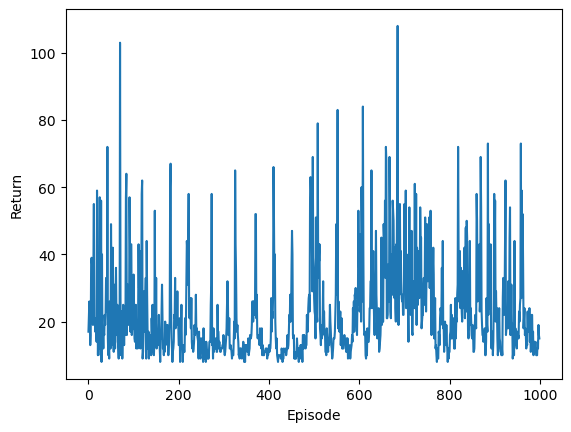

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
env = gym.make("CartPole-v1")
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_sarsa_episodic(env, model, loss_func, optimizer, device, 1000)
env.close()
print(np.sum(returns) / len(returns))
plot_returns(returns)

device: cuda
45.043


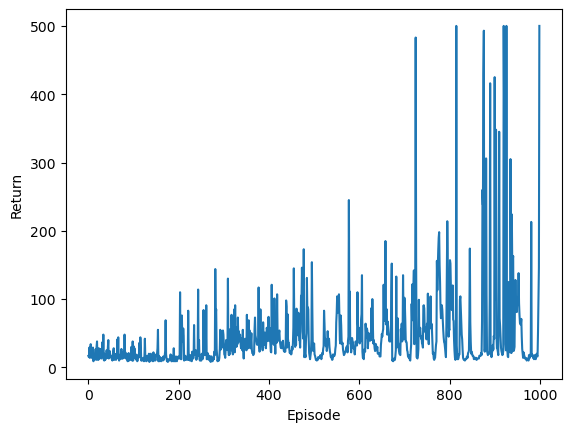

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
env = gym.make("CartPole-v1")
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_sarsa_episodic(env, model, loss_func, optimizer, device, 1000)
env.close()
print(np.sum(returns) / len(returns))
plot_returns(returns)

In [6]:
def train_qlearning_episodic(env, model, loss_func, optimizer, device, num_episodes):
    eps = 1
    returns = []
    for ep in range(num_episodes):
        observation, info = env.reset()
        state = torch.tensor(observation, device=device)
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            action = select_action_eps_greedy(env, model, state, eps)
            estimated_value = model(state)[action] # Q(s,a)
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = torch.tensor(observation, device=device)
            G += reward

            if terminated:
                update_model(loss_func, optimizer, torch.tensor(reward, device=device), estimated_value)
            else:
                with torch.no_grad():
                    max_estimated_next_value = torch.max(model(next_state)) # max_a' Q(s',a')
                update_model(loss_func, optimizer, reward + max_estimated_next_value, estimated_value)
                state = next_state

        eps = update_eps(eps)
        returns.append(G)
    return returns

device: cuda
20.987


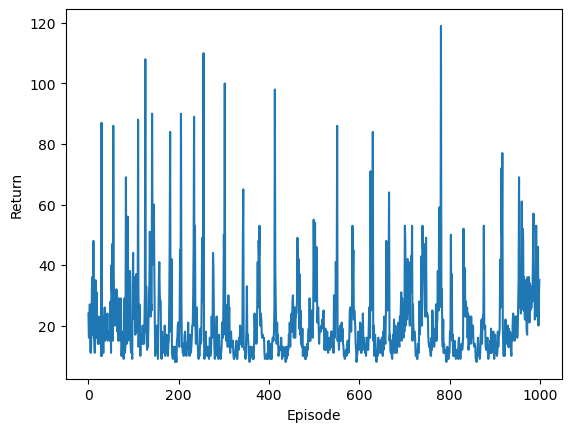

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
env = gym.make("CartPole-v1")
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_qlearning_episodic(env, model, loss_func, optimizer, device, 1000)
env.close()
print(np.sum(returns) / len(returns))
plot_returns(returns)

device: cuda
65.618


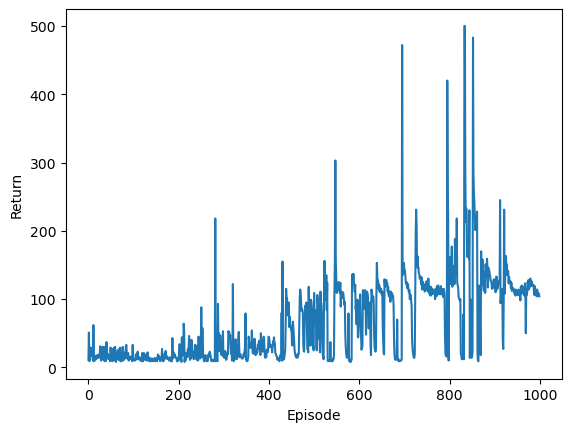

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
env = gym.make("CartPole-v1")
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_qlearning_episodic(env, model, loss_func, optimizer, device, 1000)
env.close()
print(np.sum(returns) / len(returns))
plot_returns(returns)